<h1><center>Anomaly Detection su Serie Temporali</h1></center>
<h3><center>Usando Machine Learning (Deep Learning)</h3></center>

(4)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image

plt.rcParams['figure.figsize'] = (16, 6)
pd.options.display.max_colwidth = 30
pd.options.display.max_columns = 100

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
# %load data_loader.py
from sklearn import preprocessing

class SocLoader(object):

    def __init__(self, file, train_test_split=0.8):
        
        self.train_test_split = train_test_split
        
        df = pd.read_csv(file, parse_dates=True, index_col='datetime')
        df = df[df.s5ApnDownlinkBytes < 1e13]
        df['is_ibox'] = (df.GGSN_J20_APN == 'ibox.tim.it').astype(int)

        df = df.dropna().sort_index()
        df['dayofweek'] = df.index.dayofweek
        df['timeofday'] = df.index.hour * 60 + df.index.minute
        df['is_ibox'] = df['GGSN_J20_APN'] == 'ibox.tim.it'

        self.encoder = preprocessing.LabelEncoder()
        df['ggs_name'] = self.encoder.fit_transform(df['GGSN_J20'].values)
        df = df.reset_index().set_index(['GGSN_J20', 'GGSN_J20_APN', 'datetime']).sort_index()

        targets = df[['ggsnApnDownlinkBytes-s5ApnDownlinkBytes',
                          's5ApnDownlinkBytes']].values.astype(np.float32)

        float_features = df[['ggsnApnActivePdpContextCount', 'pgwApnActiveEpsBearer',
            'ggsnApnAttemptedActivation', 'pgwApnAttemptedEpsBearerActivation',
            'timeofday']].values.astype(np.float32)


        feature_scaler = preprocessing.MinMaxScaler()
        target_scaler = preprocessing.MinMaxScaler()

        self.float_features = feature_scaler.fit_transform(float_features)
        self.targets = target_scaler.fit_transform(targets)

        self.int_features = df[['ggs_name', 'is_ibox', 'dayofweek']].values.astype(np.int64)

        
        dfa = pd.DataFrame(self.targets, columns=['download3G', 'download4G'])
        
        dfa = dfa.join(pd.DataFrame(self.float_features, columns=\
                ['sessions3G', 'sessions4G', 'attempted3G', 'attempted4G', 'timeofday']))
        
        dfa = dfa.join(pd.DataFrame(self.int_features, columns=\
                                    ['ggs_name', 'is_ibox', 'dayofweek']))
        
        self.df = dfa

        print('float features', self.float_features.shape)
        print('int features', self.int_features.shape)
        print('targets', self.targets.shape)
    
    
    @property
    def data_size(self):
        return len(self.df)

    @property
    def num_names(self):
        return len(self.encoder.classes_)
    
    
    def batch_generator(self, batch_size=32, sequence_len=100, stride=1, \
                    training=True, shuffle=True):

        num_records = self.float_features.shape[0]
        train_test_index = int(num_records * self.train_test_split)

        basic_range = np.arange(sequence_len)
        basic_range = np.tile(basic_range, (batch_size, 1))

        if training:
            indices = np.arange(0, train_test_index - sequence_len)
        else:
            indices = np.arange(train_test_index, num_records - sequence_len)

        if shuffle:
            np.random.shuffle(indices)


        for i in range(0, len(indices), batch_size * stride):
            idx = indices[i: i + batch_size]
            try:
                idx = (idx[:, None] + basic_range).ravel()
                targets = self.targets[idx].reshape([batch_size, sequence_len, self.targets.shape[1]])
                float_features = self.float_features[idx]
                float_features = float_features.reshape([batch_size, sequence_len, self.float_features.shape[1]])
                int_features = self.int_features[idx]
                int_features = int_features.reshape([batch_size, sequence_len, self.int_features.shape[1]])

            except Exception as e:
                print(e)
                raise StopIteration

            yield float_features, int_features, targets

            
SocLoader('BITRATE_contatori_grezzi.csv').df.head()

('float features', (239114, 5))
('int features', (239114, 3))
('targets', (239114, 2))


,download3G,download4G,sessions3G,sessions4G,attempted3G,attempted4G,timeofday,ggs_name,is_ibox,dayofweek
0,0.461842,0.115712,0.126788,0.060573,0.000297,0.000132,0.000000,0,1,3
1,0.419722,0.102276,0.124378,0.059826,0.000268,0.000114,0.010526,0,1,3
2,0.366519,0.094812,0.122429,0.059071,0.000249,0.000103,0.021053,0,1,3
3,0.325251,0.077404,0.120441,0.058540,0.000242,0.000173,0.031579,0,1,3
4,0.280296,0.064960,0.116844,0.057584,0.000479,0.001082,0.042105,0,1,3


('float features', (239114, 5))
('int features', (239114, 3))
('targets', (239114, 2))


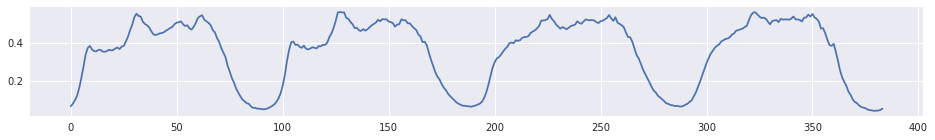

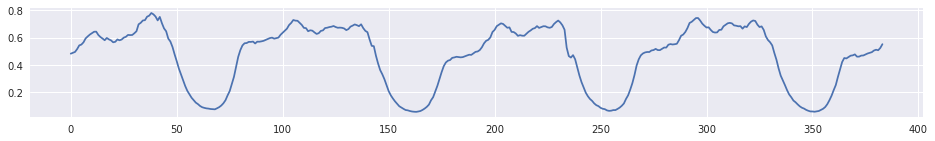

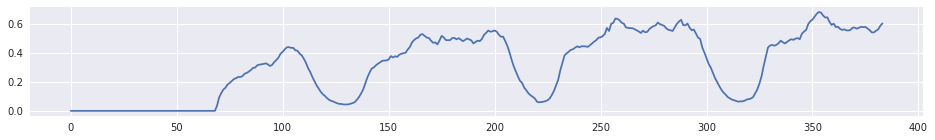

In [3]:
loader = SocLoader('BITRATE_contatori_grezzi.csv')

i = 0
for float_features, int_features, targets in loader.batch_generator(batch_size=1, sequence_len=96*4):
#     print(float_features)
#     print(int_features)
#     print(targets)
    _ = plt.figure(figsize=(16, 2))
    _ = plt.plot(targets[:, :, 0].reshape(-1, 1))
    i +=1
    if i > 2: break

In [4]:
# %load plot_some.py
def plot_some(ytrue, yhat, forecast_steps=0, max_steps = 7 * 96):
    ytrue = ytrue[:, forecast_steps :, :]
    ytrue = ytrue.reshape(-1, ytrue.shape[-1])
    yhat = yhat.reshape(-1, yhat.shape[-1])

    max_steps = 7 * 96
    num_std = 3
    error_std = 4.5
    if yhat.shape[0] > max_steps:
        ytrue = ytrue[:max_steps]
        yhat = yhat[:max_steps]

    x = np.arange(yhat.shape[0])

    plt.clf()

    plt.subplot(211)
    plt.plot(ytrue[:, 0], color='navy')
    mu = yhat[:, 0]
    plt.plot(x, mu, color='darkorange')
    plt.ylim(0, 1)

    if yhat.shape[-1] == 4:
        std = np.exp(yhat[:, 2])
        plt.fill_between(x, mu - num_std * std, mu + num_std * std, alpha=0.2, color='darkorange')
        plt.fill_between(x, mu - std, mu + std, alpha=0.3, color='darkorange')

        anomalous = mu - ytrue[:, 0] > error_std * std
        plt.plot(anomalous, color='red')

    plt.subplot(212)
    plt.plot(ytrue[:, 1], color='navy')
    mu = yhat[:, 1]
    plt.plot(x, mu, color='darkorange')
    plt.ylim(0, 1)

    if yhat.shape[-1] == 4:
        std = np.exp(yhat[:, 3])
        plt.fill_between(x, mu - num_std * std, mu + num_std * std, alpha=0.2, color='darkorange')
        plt.fill_between(x, mu - std, mu + std, alpha=0.3, color='darkorange')

        anomalous = mu - ytrue[:, 1] > error_std * std
        plt.plot(anomalous, color='red')

In [5]:
import itertools
import torch
import torch.nn as nn

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

class LaplaceLikelihood(nn.Module):
    def __init__(self):
        super(LaplaceLikelihood, self).__init__()

    def forward(self, output, y):
        mu, log_sigma = torch.chunk(output, 2, dim=2)
        sigma = torch.exp(log_sigma)
        logp = -torch.abs(y - mu) / sigma - np.log(2) - log_sigma
        logp = torch.sum(logp, 2)
        logp = torch.mean(logp)
        return -logp

## WaveNet
L'architettura **WaveNet** è stata introdotta da DeepMind nel settembre del 2016 ed è stato un balzo in avanti importante nella sintesi del segnale audio.

https://deepmind.com/blog/wavenet-generative-model-raw-audio/

http://deepsound.io/wavenet_first_try.html

Caratteristiche WaveNet
1. **Fully-Convolutional**.

2. **Dilated Convolutions**.

3. **Causal Convolutions**.

4. **Residual Blocks**.

5. **Gated Activation Units.**

## Dilated Convolutions
WaveNet introduce per la prima volta il concetto delle **Convoluzioni Dilatate** (Dilated Convolutions, Atrous Convolutions) dimostrando la loro incredibile capacità espressiva.

Le Convoluzioni dilatate sono dei filtri (kernel) che hanno lo stesso costo computazionale dei filtri normali ma hanno la capacità di allargare il **receptive feild** della rete in modo esponenziale.

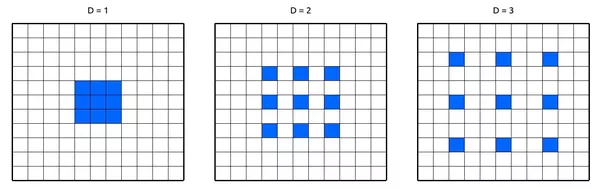

In [6]:
Image('pics/dilated_convs2.png', width=1000)

## Crescita esponenziale del receptive field

Nelle convoluzioni il concetto fondamentale è il **receptive field** ossia l'ampiezza dei filtri. Più il receptive field è ampio e più si possono scoprire correlazioni tra punti (es pixels) lontani tra loro.

- All'inizio si usavano filtri grandi ~7x7, (anche 11x11 in AlexNet 2012)


- Poi si è scoperto che funzionano meglio filtri piccoli (3x3 VGG e ResNet) e mettere molti layers. Il receptive field aumenta **linearmente** da layer a layer.


- Le convoluzioni dilatate aumentano il receptive field **esponenzialmente** da layer a layer. Possono correlare osservazioni che si trovano lontanissime tra loro, ad esempio con 10 layers si cattura un receptive field di $2^{10} = 1024$

## Convoluzioni Causali
Una seconda innovazione di WaveNet sono le **Convoluzioni Causali**.

- Nelle convulizioni i filtri (kernel) "vedono" in modo simmetrico una parte sinistra e una parte destra del loro input.


- Volendo adattare le convoluzioni su serie temporali dove c'è un prima e un dopo volgiamo che i punti futuri dipendano dal passato ma non il viceversa.


- Le convoluzioni causali sono solo un modo per rispettare questa causalità temporale e si implementano semplicemente con delle forme di masceramento dell'input.


Le convuluzioni dilatate causali rendono il modello **autoregressivo** come le reti ricorrenti, ma sono circa 20 volte più veloci perché sono parallele e non sequenziali come le RNN.

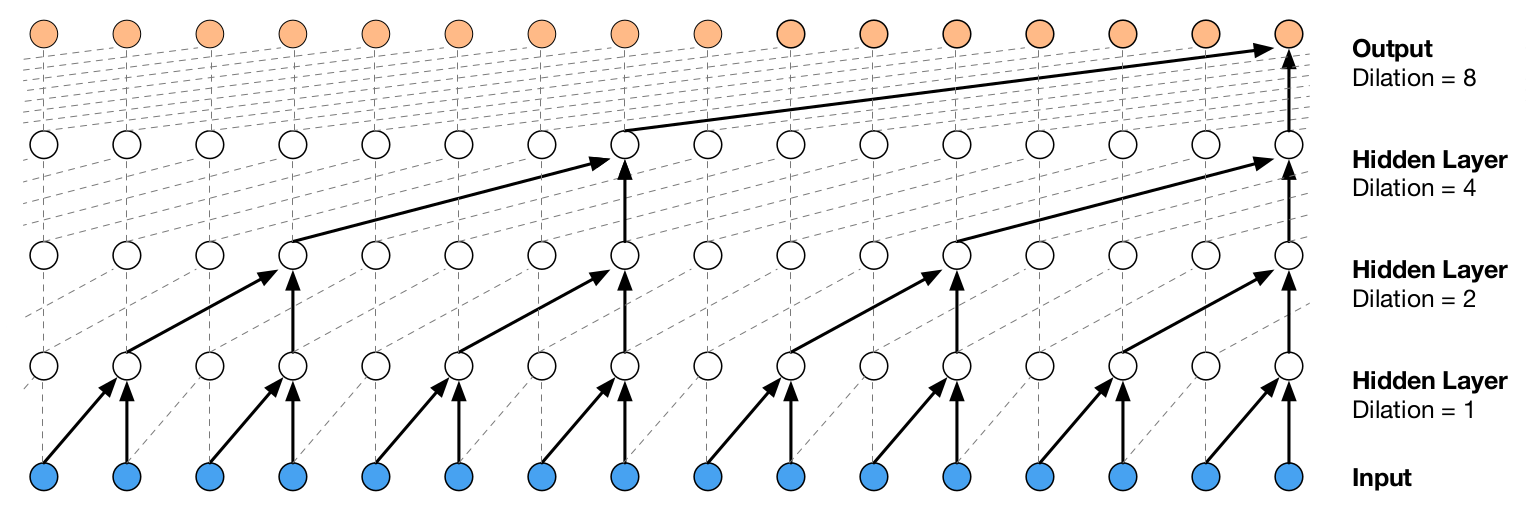

In [7]:
Image('pics/dilated_convs.png', width=1300)

In [8]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, feature_maps, dilation, kernel_size=2, activation=nn.ReLU()):
        super(ResidualBlock, self).__init__()

        self.activation = activation

        self.pad = (0, 0, (kernel_size - 1) * dilation, 0)

        self.conv_start = nn.Conv1d(2 * feature_maps, feature_maps, kernel_size=1, bias=False)

        self.dilate_out = nn.Conv1d(feature_maps, feature_maps, kernel_size=kernel_size,
                                        dilation=dilation, padding=0, bias=False)

        self.dilate_gate = nn.Conv1d(feature_maps, feature_maps, kernel_size=kernel_size,
                                        dilation=dilation, padding=0, bias=False)
        
        self.conv_finish = nn.Conv1d(feature_maps, 2 * feature_maps, kernel_size=1, bias=False)


    def forward(self, inputs):
        activation = self.activation
        out = activation(inputs)
        out = activation(self.conv_start(out))
        
        # need to transform into a 4D tensor and pad
        out = out.unsqueeze(3)
        padded = F.pad(out, self.pad)
        # restore dimensions
        padded = padded.squeeze(3)
        out = self.dilate_out(padded)
        gate = self.dilate_gate(padded)
        
        out = F.tanh(out) * F.sigmoid(gate)
        
        out = out.narrow(2, 0, inputs.size(2))
        out = activation(self.conv_finish(out))
        out = out + inputs
        return out



class WaveNet(nn.Module):
    def __init__(self, num_names, input_size, embed_size=3, num_blocks=1, dilation_rate=7,
                 feature_maps=32, activation=nn.ReLU()):
        super(WaveNet, self).__init__()

        self.embed_week = nn.Embedding(7, embed_size)
        self.embed_name = nn.Embedding(num_names, embed_size)

        input_size += 2 * (embed_size - 1)
        # this conv1d serves to project the input to twice the feature maps
        self.conv_in = nn.Conv1d(input_size, 2 * feature_maps, kernel_size=1, bias=False)

        modules = []
        for block in range(num_blocks):
            for rate in range(dilation_rate + 1):
                residual = ResidualBlock(feature_maps, 2 ** rate, kernel_size=2, activation=activation)
                modules.append(residual)

        self.blocks = nn.ModuleList(modules)
        self.conv_out = nn.Conv1d(2 * feature_maps, 4, kernel_size=1, bias=False)



    def forward(self, float_features, int_features, autoregression=None):
        name = self.embed_name(int_features[:, :, 0])
        week = self.embed_week(int_features[:, :, 2])
        is_ibox = int_features[:, :, 1:2].float()

        if autoregression is None:
            features = torch.cat((float_features, name, is_ibox, week), 2)
        else:
            features = torch.cat((autoregression, float_features, name, is_ibox, week), 2)

        # in torch shape is (batch, channels, height, width)
        features = torch.transpose(features, 1, 2)
        features = self.conv_in(features)

        for residual in self.blocks:
            new_features = residual(features)
            features = new_features #+ features

        output = self.conv_out(features)
        output = torch.transpose(output, 1, 2)
        return output

## Residual Blocks
Residual Networks sono state indodotte alla fine del 2015 e sono diventate lo stato dell'arte per aumentare notevolmente la profondità delle reti, fino a 100 e oltre.

Sono una successione ripetuta di blocchi, ciascuno con il seguente schema:

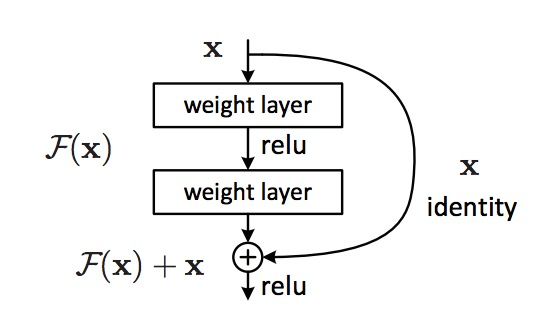

In [9]:
Image('pics/residual_block.jpg', width=700)

Siccome l'input $x$ di ciascun blocco viene sommato poi all'output del blocco, ciò che imparano è il _residuo_, ossia la differenza rispetto all'input.

$$ \mathcal{H}(x) = \mathcal{F}(x) + x $$

La ragione per cui le ResNet sono così efficaci, è che durante la back-prop il gradiente può seguire le scorciatoie (skip connections) e raggiungere i layer iniziali senza subire il fenomeno del 'vanishing gradient' dovuto alle non-linearità nel percorso.

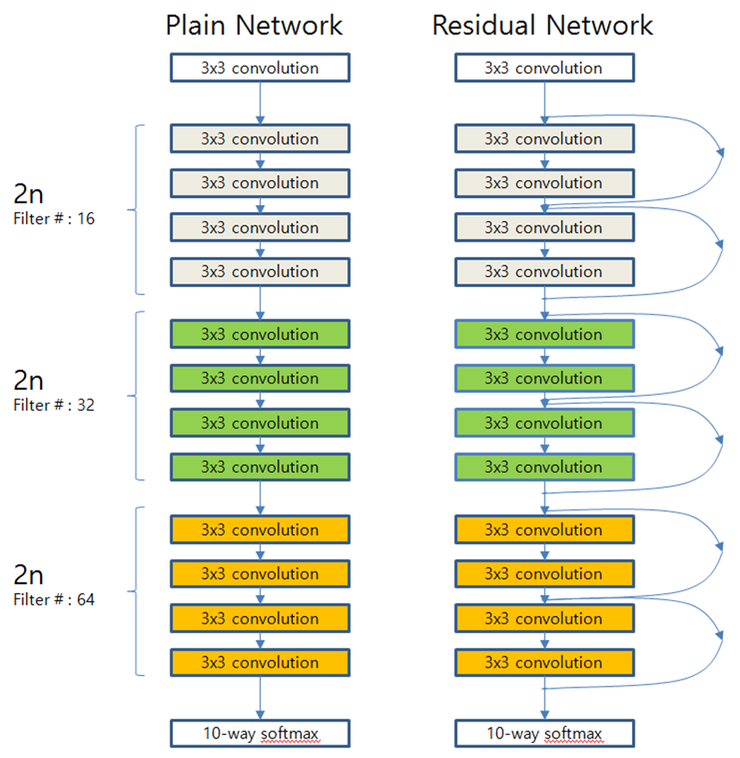

In [10]:
Image('pics/resnet.png', width=1000)

## Gated Activation Units
Le gated activations stanno diventando popolari. Si ispirano un po' al funzionamento internoi delle celle LSTM in cui l'input segue strade parallele.

2 percorrsi:
1. uno è il principale con la non-linearità che serve, es. ReLU, ELU, tanh, o addirittura con solo una trasformazione lineare
2. il secondo è un interrutore zero-uno del primo. Si ottiene con la sigmod.

Mandando la sigmoid in saturazione la rete impara a modulare quando bloccare o fare passare le porzioni dell'input che servono.

Notate che le sigmoid che sono desuete nei livelli intermedi (si usavano negli anni 90 e si usano ora solo nell'output se abbiamo una regressione logistica), stanno diventando popolari con questi gateway.

Funzionano perché anche qui il gradiente può fluire non tanto dalla strada che contiene la sigmoid, ma dall'altra.

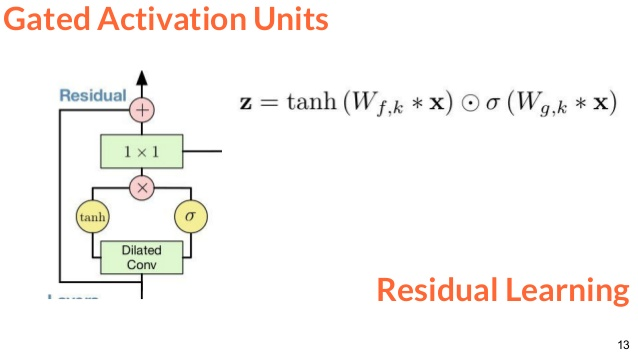

In [11]:
Image('pics/gated-activations.jpg', width=1000)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

file = 'BITRATE_contatori_grezzi.csv'
loader = SocLoader(file, train_test_split=0.95)

num_features = 10
model = WaveNet(loader.num_names, input_size=num_features, num_blocks=2, dilation_rate=8)
model.cuda()

('float features', (239114, 5))
('int features', (239114, 3))
('targets', (239114, 2))


AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [ ]:
from IPython import display
import time

criterion = LaplaceLikelihood()
criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=5e-4)

checkpoint = torch.load(r'bytenet_2blocks8dil.pth')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Turn on training mode which enables dropout.
model.train()

batch_size = 20
sequence_len = 96 * 3
num_epochs = 20
forecast_steps = 96


for epoch in range(num_epochs):
    total_loss = 0
    it = 0
    for float_features, int_features, targets in loader.batch_generator(
                            batch_size, sequence_len, stride=16):
        
        float_features = float_features[:, forecast_steps:, :]
        int_features = int_features[:, forecast_steps:, :]
        real_targets = targets[:, forecast_steps:, :]
        autoregression = None if forecast_steps == 0 else targets[:, :-forecast_steps, :]

        float_features_var = Variable(torch.from_numpy(float_features).cuda())
        int_features_var = Variable(torch.from_numpy(int_features).cuda())
        targets_var = Variable(torch.from_numpy(real_targets).cuda())
        autoregression_var = None if autoregression is None else Variable(torch.from_numpy(autoregression).cuda())

        model.zero_grad()

        output = model(float_features_var, int_features_var, autoregression_var)
        loss = criterion(output, targets_var)
        loss.backward()
        optimizer.step()

        total_loss += loss
        it += 1

#     torch.save({
#         'epoch': epoch + 1,
#         'state_dict': model.state_dict(),
#         'optimizer': optimizer.state_dict(),
#     }, r'bytenet_2blocks7dil.pth')


    plt.gca().cla() 
    plot_some(real_targets, output.data.cpu().numpy(), 0)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print('Epoch {} train loss {}'.format(epoch + 1, total_loss / it))

#plt.close()

In [ ]:
# sampler
checkpoint = torch.load(r'bytenet_2blocks8dil.pth')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

for float_features, int_features, targets in loader.batch_generator(
                        1, sequence_len * 3, training=False):
    
    float_features = float_features[:, forecast_steps:, :]
    int_features = int_features[:, forecast_steps:, :]
    real_targets = targets[:, forecast_steps:, :]
    autoregression = None if forecast_steps == 0 else targets[:, :-forecast_steps, :]

    float_features_var = Variable(torch.from_numpy(float_features).cuda(), volatile=True)
    int_features_var = Variable(torch.from_numpy(int_features).cuda(), volatile=True)
    targets_var = Variable(torch.from_numpy(real_targets).cuda(), volatile=True)
    autoregression_var = None if autoregression is None \
        else Variable(torch.from_numpy(autoregression).cuda(), volatile=True)

    output = model(float_features_var, int_features_var, autoregression_var)
    loss = criterion(output, targets_var)
        
    plt.gca().cla() 
    plot_some(real_targets, output.data.cpu().numpy(), 0)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    print('test loss {}'.format(loss))
    
    time.sleep(2.0)
